# 텍스트 전처리

## 필요라이브러리 임포트

In [1]:
# pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# train, test 분리
from sklearn.model_selection import train_test_split

# kiwi 형태소 분석기
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

# 임베딩 위한 tensorflow 임포트
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences


2023-02-16 13:33:29.689029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 13:33:30.387343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-16 13:33:30.387428: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-16 13:33:30.387436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
df = pd.read_csv('/home/minalang/rnn_lstm_gru/230216_klue_tc.csv', index_col=0)
df.head()
# 0이 스포츠, 1이 정치

,new_title,topic_idx
0,김영남 우리 민족 위상 과시…뜨거운 분위기 이어가길,1
1,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리,1
2,박대통령 한일 합의에 소녀상 언급없어…선동하면 안돼,1
3,민주 국회의원 재보선 4곳 후보 공모에 7명 신청,1
4,박찬호 현진이 10승 하니깐 생각이 나는데…,0


## 1. 필요한 문자(한글, 알파벳, 숫자, 특수부호 등)만 선택

In [3]:
df.drop_duplicates(subset = ['new_title'], inplace=True) # 중복 제거
# 이모지 제거 위해 한글, 알파벳, 공백이 아닌 것은 모두 제거
df['new_title']=df['new_title'].str.replace(pat=r'[^ㄱ-힣|a-zA-Z| ]+', repl= r' ', regex=True)
df['new_title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
df = df.dropna(how='any') # Null 값 제거
print('전처리 후 데이터 샘플의 개수 :',len(df))

전처리 후 데이터 샘플의 개수 : 13684


In [4]:
df.head()

,new_title,topic_idx
0,김영남 우리 민족 위상 과시 뜨거운 분위기 이어가길,1
1,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리,1
2,박대통령 한일 합의에 소녀상 언급없어 선동하면 안돼,1
3,민주 국회의원 재보선 곳 후보 공모에 명 신청,1
4,박찬호 현진이 승 하니깐 생각이 나는데,0


## 2. kiwi로 형태소 분석하기 + 기본형 복원

In [5]:
# kiwi 사용하기
kiwi = Kiwi()
kiwi.prepare() # 전처리 위한 준비
stopwords = Stopwords() # 불용어 사전 불러오기

In [6]:
def kiwi_preprocess(sen):
    tokens = kiwi.tokenize(sen, stopwords = stopwords)
    morph_list = [word + ('다' if tag.startswith('V') else '') for word, tag, _, _ in tokens]
    return " ".join(morph_list)

In [7]:
str_list = df['new_title'].tolist()
new_list = []
for s in str_list:
    new_list.append(kiwi_preprocess(s))
df['tokenized'] = new_list

In [8]:
df.head(11)

,new_title,topic_idx,tokenized
0,김영남 우리 민족 위상 과시 뜨거운 분위기 이어가길,1,김영남 민족 위상 과시 뜨겁다 분위기 잇다 가다 ᆯ
1,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리,1,적극 행정 추진 전략 및 성과 공유 대회 참석 이낙연 총리
2,박대통령 한일 합의에 소녀상 언급없어 선동하면 안돼,1,박 대통령 한일 합의 소녀상 언급 선동 안
3,민주 국회의원 재보선 곳 후보 공모에 명 신청,1,민주 국회 의원 재보선 곳 후보 공모 명 신청
4,박찬호 현진이 승 하니깐 생각이 나는데,0,박찬호 현진이 승 니깐 생각 나다 데
5,현행 헌법과 다른 점은 지방자치 경제민주화 개념 강화,1,현행 헌법 다르다 점 지방 자치 경제 민주 개념 강화
6,고군분투 시즌 서재덕 MVP 덕큐리로 활짝 웃다종합,0,고군분투 시즌 서재덕 MVP 덕큐리 활짝 웃다 종합
7,트럼프 유조선 공격 사소한 일 이란과 충돌우려 속 수위조절,1,트럼프 유조선 공격 사소 이란 충돌 우려 속 수위 조절
8,이희호 여사 청경호 일로 만료 당분간 경호 유지될 듯,1,이희호 여사 청 경호 만료 당분간 경호 유지 듯
9,통일농구 오늘은 친선 남북대결 김정은 관전 가능성,1,통일 농구 오늘 친선 남북 대결 김정은 관전 가능


In [9]:
# train, test 데이터 분리
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 10947
테스트용 리뷰의 개수 : 2737


## 3. tensorflow 이용한 임베딩

### 1) 문자열 길이 분포 확인

스포츠 기사제목의 중위값 길이 : 9.0
정치 기사제목의 중위값 길이 : 9.0


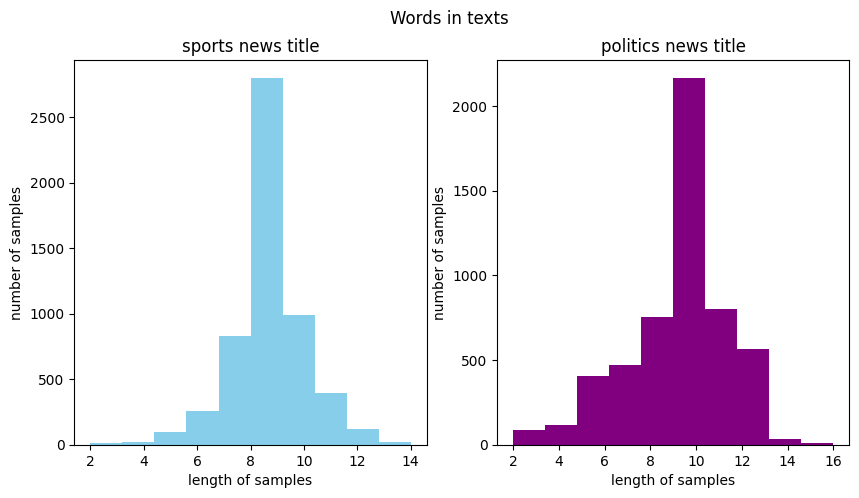

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['topic_idx']==0]['tokenized'].map(lambda x: len(x.split(' ')))
ax1.hist(text_len, color='skyblue')
ax1.set_title('sports news title')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('스포츠 기사제목의 중위값 길이 :', np.median(text_len))

text_len = train_data[train_data['topic_idx']==1]['tokenized'].map(lambda x: len(x.split(' ')))
ax2.hist(text_len, color='purple')
ax2.set_title('politics news title')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('정치 기사제목의 중위값 길이 :', np.median(text_len))
plt.show()
#넉넉잡아 16으로 하기로 함

In [11]:
X_train = train_data['tokenized'].values
y_train = train_data['topic_idx'].values
X_test= test_data['tokenized'].values
y_test = test_data['topic_idx'].values

In [12]:
train_data['tokenized'].values

array(['이목희 여 경제 위기 뒤집어씌우다 전술 선거 활용', '프로 농구 결산 허훈 안영주 뜨다 김주성 은퇴',
       '그래픽 러시아 월드컵 F 조 한국 멕시코 전력 분석', ...,
       'ITU 북한 위성 발사 계획 통보 시기 안 밝히다 보다',
       '한국 전 대 레이스 점화 황교안 오세훈 외연 확장 경쟁 종합',
       '여자 배구 디우프 어 나이 외국인 선수 막차 선수단 합류'], dtype=object)

### + 단어빈도 확인

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11799
등장 빈도가 1번 이하인 희귀 단어의 수: 4810
단어 집합에서 희귀 단어의 비율: 40.76616662429019
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.957740672026386


### 2) 고유한 인덱스 부여 + 패딩
credits: https://han-py.tistory.com/284

In [14]:
# 가장 빈도가 높은 11,800개의 단어만 선택하도록하는 Tokenizer 객체
tokenizer = Tokenizer(num_words = 11800, oov_token="<OOV>") #이후 test set에서 out of vocab에 대한 처리

# 그에 맞게 단어 인덱스를 구축
tokenizer.fit_on_texts(X_train)

# 고유한 사전으로 저장
word_dic = tokenizer.word_index

# 사전의 크기 측정
print(len(word_dic))

# 사전의 크기를 max_features 변수에 저장
max_features = len(word_dic)
# '<OOV>': 1 포함하여 총 11800

11800


In [15]:
word_dic

{'<OOV>': 1,
 '대통령': 2,
 '종합': 3,
 '북': 4,
 '박': 5,
 '문': 6,
 '감독': 7,
 '프로': 8,
 '농구': 9,
 '서': 10,
 '전': 11,
 '대표': 12,
 '경기': 13,
 '팀': 14,
 '배구': 15,
 '정상': 16,
 '첫': 17,
 '위': 18,
 '축구': 19,
 '여자': 20,
 '회담': 21,
 '월드컵': 22,
 '시즌': 23,
 '류현진': 24,
 '선수': 25,
 '국회': 26,
 '연승': 27,
 '당': 28,
 '한국': 29,
 '청': 30,
 '안': 31,
 '김정은': 32,
 '남북': 33,
 '여': 34,
 '차': 35,
 '만': 36,
 '일': 37,
 '리그': 38,
 '승': 39,
 '골': 40,
 '아시안': 41,
 'mlb': 42,
 '북한': 43,
 '꺾다': 44,
 '보': 45,
 '대': 46,
 '점': 47,
 '게임': 48,
 '정부': 49,
 '홈런': 50,
 '손흥민': 51,
 'sk': 52,
 '평양': 53,
 '여야': 54,
 '연속': 55,
 '우승': 56,
 '연패': 57,
 '무': 58,
 '올림픽': 59,
 '나': 60,
 '승리': 61,
 '대회': 62,
 '강': 63,
 '회의': 64,
 '야구': 65,
 '개': 66,
 '호': 67,
 '한국당': 68,
 '민주': 69,
 'nba': 70,
 '가능': 71,
 '야': 72,
 '경제': 73,
 '의원': 74,
 '이닝': 75,
 '총리': 76,
 '대북': 77,
 '두산': 78,
 '월': 79,
 '국민': 80,
 '번': 81,
 '안타': 82,
 '후보': 83,
 '핵': 84,
 '권': 85,
 '부상': 86,
 '째': 87,
 'lg': 88,
 '복귀': 89,
 '실점': 90,
 '출전': 91,
 '위원장': 92,
 '다저스': 93,
 '

In [16]:
max_len = 16

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [17]:
X_train[3]

array([   0,    0,    0,    0,    0,   72, 2954,  954,  432, 4075,  456,
         74, 1684,  362,    3,   45], dtype=int32)

In [18]:
X_train.shape

(10947, 16)

## 4. pytorch 활용하여 데이터셋 만들기

In [19]:
#파이토치의 랜덤시드 고정
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42) # gpu 1개 이상일 때 

# 넘파이 랜덤시드 고정
np.random.seed(42)

In [20]:
# numpy의 ndarray형태의 train,test데이터셋을 tensor데이터셋으로 변환
train_dataset = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))

In [21]:
# batch단위로 데이터를 변환하는 DataLoader 작성
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

batch size확인

In [22]:
# check our batches
dataiter = iter(train_loader) # 순회가능한 객체를 받음(여기서는 batch)
x, y = next(dataiter) # 반복 가능한 객체의 다음 값(여기서는 첫번째 batch)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample label size: ', y.size())   # batch_size

Sample batch size:  torch.Size([64, 16])
Sample label size:  torch.Size([64])


In [23]:
x 

tensor([[   0,    0,    0,  ..., 1412, 4377,  816],
        [   0,    0,    0,  ...,  195, 2232, 1975],
        [   0,    0,    0,  ...,   37,  420,  557],
        ...,
        [   0,    0,    0,  ...,  838,  674,  107],
        [   0,    0,    0,  ..., 1416, 4506,   16],
        [   0,    0,    0,  ..., 5237,  255,   71]], dtype=torch.int32)

In [24]:
y

tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [25]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))

Using cuda


## 5. 모델 정의

### 1) stackedRnn
credits: 동호 코드

In [26]:
class StackedRnn(nn.Module):
  def __init__(self):
    super(StackedRnn, self).__init__()
    self.embedding = nn.Embedding(max_features, 128) # 임베딩을 할 단어의 개수, 임베딩 할 차원
    # pytorch의 경우 default로 모든 노드의 은닉벡터를 리턴함(return_sequences안해도 됨!)
    self.rnn = nn.RNN(128, 32, 4, nonlinearity='tanh', batch_first = True) 
    #input, hidden, num_layers, activation function, batch_first = 입력텐서의 첫번째 차원이 배치크기
    self.fc = nn.Linear(32,2) #sports or pol

  def forward(self, x):
    x = self.embedding(x)
    o, _ = self.rnn(x) # output과 tensor shape을 출력하기 때문에 tensor shape _로 받아줌
    o = o[:, -1, :] # 가장 마지막 단어의 임베딩 값
    output = self.fc(o)
    return output

### ***모델의 구조에 대해 더 들어가기***

In [27]:
sample = next(iter(train_loader))

In [28]:
# 임베딩, rnn 레이어 분해
x1 = nn.Embedding(max_features, 128)(sample[0])
o, _ = nn.RNN(128, 32, 4, nonlinearity='tanh', batch_first = True)(x1) #input, hidden, num_layers

In [29]:
x1.shape # 한 배치 당 64개의 데이터셋 한 데이터셋 당 형태소 16개, 128차원의 벡터로 임베딩

torch.Size([64, 16, 128])

In [30]:
x1[0].shape # 16개의 단위로 구성된 문장에 대해 128차원의 벡터로 임베딩

torch.Size([16, 128])

In [31]:
o.shape # (배치크기, 시퀀스길이, 은닉 상태의 크기)

torch.Size([64, 16, 32])

In [32]:
_.shape # (층의 개수, 배치 크기, 은닉 상태의 크기)

torch.Size([4, 64, 32])

### 2) Basic GRU
사실 RNN 층만 GRU층으로 바꾸어주면 됨

In [42]:
class BasicGRU(nn.Module):
    def __init__(self):
        super(BasicGRU, self).__init__()
        self.embedding = nn.Embedding(max_features, 128)
        self.gru = nn.GRU(128, 32, 4, batch_first = True)
        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        x = self.embedding(x)
        o, _ = self.gru(x)
        o = o[:, -1, :]
        output = self.fc(o)
        return output    

### 3) Basic LSTM

In [33]:
class BasicLSTM(nn.Module):
    def __init__(self):
        super(BasicLSTM, self).__init__()
        self.embedding = nn.Embedding(max_features, 128)
        self.lstm = nn.LSTM(128, 32, 4, batch_first = True)
        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        x = self.embedding(x)
        o, _ = self.lstm(x)
        o = o[:, -1, :]
        output = self.fc(o)
        return output 

In [47]:
## 같은 코드 nn.Sequential로 짜보기
class SeqLSTM(nn.Module):
    def __init__(self):
        super(SeqLSTM, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Embedding(max_features, 128)
        )
        # nn.LSTM내에서 dropout, bidirectional 등의 변형이 가능하기 때문에 nn.Dropout등의 layer사용은 불필요함
        self.layer2 = nn.Sequential(
            nn.LSTM(128, 32, 4, batch_first = True)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(32, 2)
        )
    def forward(self, x):
        x = self.layer1(x)
        o, _ = self.layer2(x)
        o = o[:, -1, :]
        output = self.layer3(o)
        return output 


In [33]:
model = StackedRnn().to(device)
model

StackedRnn(
  (embedding): Embedding(11800, 128)
  (rnn): RNN(128, 32, num_layers=4, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [43]:
model = BasicGRU()
model.to(device)
model

BasicGRU(
  (embedding): Embedding(11800, 128)
  (gru): GRU(128, 32, num_layers=4, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [48]:
model = SeqLSTM()
model.to(device)
model

SeqLSTM(
  (layer1): Sequential(
    (0): Embedding(11800, 128)
  )
  (layer2): Sequential(
    (0): LSTM(128, 32, num_layers=4, batch_first=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
)

## 6. 손실함수 및 옵티마이저 정의

In [49]:
#손실함수
criterion = nn.CrossEntropyLoss()
criterion.to(device)
#옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

## 7. 학습 및 평가 함수 정의

In [50]:
def train(model, train_loader, optimizer, criterion):
  train_loss = 0
  train_acc = 0

  # model을 "training mode"로 -> dropout이나 batch normalization이 가능해짐
  # 이 모델에서는 이를 사용하지는 않음
  model.train()

  for batch, (x, y) in enumerate(train_loader): # 배치별로
    x, y = x.to(device), y.to(device)
    out = model(x)

    # 모든 batch마다 gradient를 0으로 초기화
    optimizer.zero_grad()

    # 정답의 개수 : 예측한 값(out.argmax(1)과 y를 비교하여 맞춘 개수)
    preds = (out.argmax(1) == y).sum()
    
    # 라벨예측결과와 실제 y값을 비교하여 loss값 계산 
    loss = criterion(out, y)

    # backward()를 사용하여 역전파 수행
    loss.backward()

    # 최적화 알고리즘을 사용하여 parameter를 update
    optimizer.step()

    train_loss += loss.item()
    train_acc += preds.item()

  return train_loss / len(train_loader), train_acc / len(train_loader.dataset)
  #len(train_loader)는 배치개수, train_loader.dataset은 train_loader내 전체 데이터개수(10947)

In [51]:
def evaluate(model, test_loader, criterion):
  val_loss = 0
  val_acc = 0

  # "evaluation mode" : dropout이나 batch nomalization을 끔
  model.eval()

  # pytorch에서 gradient가 계산되지 않도록 해서 memory를 적게 쓰고 computation 속도를 높임
  with torch.no_grad():

    for batch, (x, y) in enumerate(test_loader) :
      x, y = x.to(device), y.to(device)  
      out = model(x)
      preds = (out.argmax(1) == y).sum()
      
      loss = criterion(out, y)

      val_loss += loss.item()
      val_acc += preds.item()

  return val_loss / len(test_loader), val_acc / len(test_loader.dataset)

In [52]:
import time

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

## 8. 학습 및 평가

In [53]:
N_EPOCHS = 10
t_loss = []
t_acc = []
v_loss = []
v_acc = []

best_test_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # 모델 저장
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'best-model.pt')
    t_loss.append(train_loss)
    t_acc.append(train_acc)
    v_loss.append(test_loss)
    v_acc.append(test_acc)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {100*train_acc:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {100*test_acc:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.452 | Train Acc: 76.29%
	 Val. Loss: 0.180 |  Val. Acc: 93.13%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.131 | Train Acc: 95.29%
	 Val. Loss: 0.111 |  Val. Acc: 96.02%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.069 | Train Acc: 97.76%
	 Val. Loss: 0.102 |  Val. Acc: 96.57%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.035 | Train Acc: 98.95%
	 Val. Loss: 0.111 |  Val. Acc: 96.38%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.019 | Train Acc: 99.52%
	 Val. Loss: 0.113 |  Val. Acc: 96.64%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.010 | Train Acc: 99.77%
	 Val. Loss: 0.115 |  Val. Acc: 96.89%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.007 | Train Acc: 99.82%
	 Val. Loss: 0.126 |  Val. Acc: 97.00%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.006 | Train Acc: 99.83%
	 Val. Loss: 0.137 |  Val. Acc: 96.71%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.004 | Train Acc: 99.92%
	 Val. Loss: 0.141 |  Val. Acc: 96.53%
Epoch: 10 | Epoch Time: 0m 0

## 9. 결과 시각화

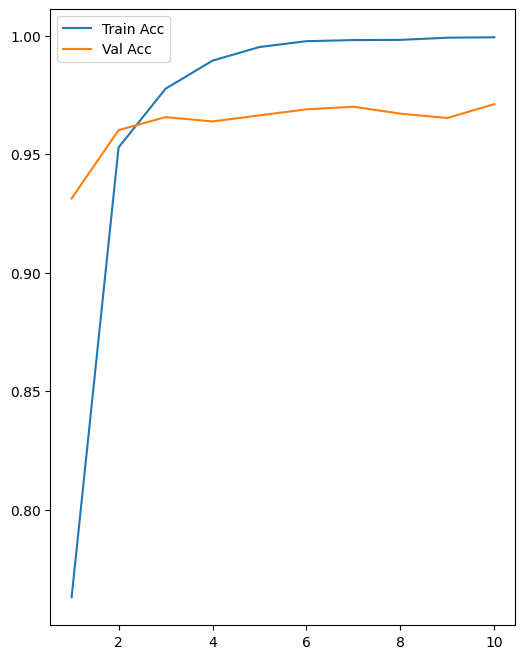

In [54]:
# 결과 시각화
plt.figure(figsize=(6, 8))
plt.plot(range(1, 11, 1), t_acc, label='Train Acc')
plt.plot(range(1, 11, 1), v_acc, label='Val Acc')
plt.legend()
plt.show()